In [1]:
# ================================================================================ #
# =========================== Goolge Colab File Upload =========================== #
# ================================================================================ #

from google.colab import drive
drive.mount('/content/drive')

from google.colab import output
# !cp 파일1 파일2 # 파일1을 파일2로 복사 붙여넣기
!cp "/content/drive/MyDrive/Colab Notebooks/동서발전 태양광 발전량 예측 경진대회/data.zip" "data.zip"
# data.zip을 현재 디렉터리에 압축해제
!unzip "data.zip"
output.clear()

In [2]:
# import library 
import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
#import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import os
import glob
import pickle

# path
path = "./"
dangjin_fcst_data_path = path + "dangjin_fcst_data.csv"
dangjin_obs_data_path = path + "dangjin_obs_data.csv"
energy_data_path = path + "energy.csv"
ulsan_fcst_data_path = path + "ulsan_fcst_data.csv"
ulsan_obs_data_path = path + "ulsan_obs_data.csv"
site_info_path = path + "site_info.csv"
dangjin_obs_2015_2018_path = path + "dangjin_obs_2015_2018.csv" # 추가 데이터
ulsan_obs_2015_2018_path = path + "ulsan_obs_2015_2018.csv"
energy_2015_2018_path = path + "energy_2015_2018.csv"

# file convert to pandas data
dangjin_fcst_data = pd.read_csv(dangjin_fcst_data_path)
dangjin_obs_data = pd.read_csv(dangjin_obs_data_path)
energy_data = pd.read_csv(energy_data_path)
ulsan_fcst_data = pd.read_csv(ulsan_fcst_data_path)
ulsan_obs_data = pd.read_csv(ulsan_obs_data_path)
site_info = pd.read_csv(site_info_path)

# 2015 - 2018 데이터 추가
dangjin_obs_2015_2018 = pd.read_csv(dangjin_obs_2015_2018_path)
ulsan_obs_2015_2018 = pd.read_csv(ulsan_obs_2015_2018_path)
energy_2015_2018 = pd.read_csv(energy_2015_2018_path)

# ======================================================================== #
# ===================== load data and preprocessing ====================== #
# ======================================================================== #

dangjin_obs_data.rename(
    columns = {
        "일시":"time",
        "기온(°C)":"Temperature",
        "풍속(m/s)":"WindSpeed",
        "풍향(16방위)":"WindDirection",
        "습도(%)":"Humidity",
        "전운량(10분위)":"Cloud"
    }, inplace = True)

ulsan_obs_data.rename(
    columns = {
        "일시":"time",
        "기온(°C)":"Temperature",
        "풍속(m/s)":"WindSpeed",
        "풍향(16방위)":"WindDirection",
        "습도(%)":"Humidity",
        "전운량(10분위)":"Cloud"
    }, inplace = True)


def preprocess_wind_NN(data):
    '''
    - data: pd.DataFrmae which contains the columns 'WindSpeed' and 'WindDirection'
    - for Neural Network version
    '''
    # degree to radian
    wind_direction_radian = data['WindDirection'] * np.pi / 180

    # polar coordinate to cartesian coordinate
    wind_x = data['WindSpeed'] * np.cos(wind_direction_radian)
    wind_y = data['WindDirection'] * np.sin(wind_direction_radian)

    # name pd.series
    wind_x.name = 'Wind_X'
    wind_y.name = 'Wind_Y'

    return wind_x, wind_y

dangjin_obs_data = dangjin_obs_data.drop(columns = ["지점", "지점명"])
ulsan_obs_data = ulsan_obs_data.drop(columns = ["지점","지점명"])

# time: convert datatype object
dangjin_obs_data["time"] = pd.to_datetime(dangjin_obs_data["time"].copy(), format='%Y-%m-%d %H:%M:%S')
dangjin_obs_data = dangjin_obs_data.astype({"time":"object"})

ulsan_obs_data["time"] = pd.to_datetime(ulsan_obs_data["time"].copy(), format='%Y-%m-%d %H:%M:%S')
ulsan_obs_data = ulsan_obs_data.astype({"time":"object"})

# energy_data, time: string -> timestamp
import datetime as dt

energy_data_time_tmp = energy_data["time"].copy()

for i in range(energy_data.shape[0]):
    if energy_data["time"][i][-8:] == "24:00:00":
        energy_data["time"][i] = energy_data_time_tmp[i].replace("24:00:00", " 00:00:00")
        energy_data["time"][i] = pd.to_datetime(energy_data["time"][i]) + dt.timedelta(days = 1)

    energy_data["time"][i] = pd.Timestamp(energy_data["time"][i])

energy_2015_2018_tmp= energy_2015_2018["time"].copy()

for i in range(energy_2015_2018.shape[0]):
    if energy_2015_2018["time"][i][-8:] == "24:00:00":
        energy_2015_2018["time"][i] = energy_2015_2018_tmp[i].replace("24:00:00", " 00:00:00")
        energy_2015_2018["time"][i] = pd.to_datetime(energy_2015_2018["time"][i]) + dt.timedelta(days = 1)

    energy_2015_2018["time"][i] = pd.Timestamp(energy_2015_2018["time"][i])


dangjin_obs_2015_2018_tmp= dangjin_obs_2015_2018["time"].copy()

for i in range(dangjin_obs_2015_2018.shape[0]):
    dangjin_obs_2015_2018["time"][i] = pd.Timestamp(dangjin_obs_2015_2018["time"][i])

ulsan_obs_2015_2018_tmp= ulsan_obs_2015_2018["time"].copy()

for i in range(ulsan_obs_2015_2018.shape[0]):
    ulsan_obs_2015_2018["time"][i] = pd.Timestamp(ulsan_obs_2015_2018["time"][i])

# object 
energy_data = energy_data.astype({"time":"object"})
dangjin_obs_data = dangjin_obs_data.astype({"time":"object"})
ulsan_obs_data = ulsan_obs_data.astype({"time":"object"})

energy_2015_2018 = energy_2015_2018.astype({"time":"object"})
dangjin_obs_2015_2018 = dangjin_obs_2015_2018.astype({"time":"object"})
ulsan_obs_2015_2018 = ulsan_obs_2015_2018.astype({"time":"object"})

# 전 데이터 NAN 처리
'''
dangjin_obs_data = dangjin_obs_data.fillna(method = "bfill")
energy_data = energy_data.fillna(method = "bfill")
ulsan_obs_data = ulsan_obs_data.fillna(method = "bfill")

dangjin_obs_2015_2018 = dangjin_obs_2015_2018.fillna(method = "bfill")
ulsan_obs_2015_2018 = ulsan_obs_2015_2018.fillna(method = "bfill")
energy_2015_2018 = energy_2015_2018.fillna(method = "bfill")
'''

dangjin_obs_data = dangjin_obs_data.dropna()
energy_data = energy_data.dropna()
ulsan_obs_data = ulsan_obs_data.dropna()

dangjin_obs_2015_2018 = dangjin_obs_2015_2018.dropna()
ulsan_obs_2015_2018 = ulsan_obs_2015_2018.dropna()
energy_2015_2018 = energy_2015_2018.dropna()

# Wind_X, Wind_Y variable add
dangjin_obs_data = dangjin_obs_data.join(preprocess_wind_NN(dangjin_obs_data))
ulsan_obs_data = ulsan_obs_data.join(preprocess_wind_NN(ulsan_obs_data))

# total dataset 구성
from functools import reduce

list_dangjin = [dangjin_obs_data, energy_data[["time","dangjin_floating","dangjin_warehouse","dangjin"]].copy()]
list_ulsan = [ulsan_obs_data, energy_data[["time","ulsan"]].copy()]

dangjin_data = reduce(lambda  left,right: pd.merge(left, right, on=['time'], how='inner'), list_dangjin)
ulsan_data = reduce(lambda  left,right: pd.merge(left, right, on=['time'], how='inner'), list_ulsan)

#ulsan_obs_2015_2018.set_index(keys = ["time"], inplace = True)
#dangjin_obs_2015_2018.set_index(keys = ["time"], inplace = True)
#energy_2015_2018.set_index(keys = ["time"], inplace = True)

#dangjin_2015_2018 = pd.concat([dangjin_obs_2015_2018, energy_2015_2018[["dangjin_floating","dangjin_warehouse","dangjin"]]], axis = 1, join = "outer").drop(columns = ["Unnamed: 0"])
#ulsan_2015_2018 = pd.concat([ulsan_obs_2015_2018, energy_2015_2018[["ulsan"]]], axis = 1, join = "outer").drop(columns = ["Unnamed: 0"])

dangjin_2015_2018 = pd.merge(dangjin_obs_2015_2018, energy_2015_2018[["time","dangjin_floating","dangjin_warehouse","dangjin"]], on = ["time"], how = "inner")
ulsan_2015_2018 = pd.merge(ulsan_obs_2015_2018, energy_2015_2018[["time","ulsan"]], on = ["time"], how = "inner")

display(dangjin_2015_2018)
display(ulsan_2015_2018)

dangjin_2015_2018 = dangjin_2015_2018.reset_index()
ulsan_2015_2018 = ulsan_2015_2018.reset_index()

dangjin_2015_2018_tmp= dangjin_2015_2018["time"].copy()

for i in range(dangjin_2015_2018.shape[0]):
    dangjin_2015_2018["time"][i] = pd.Timestamp(dangjin_2015_2018["time"][i])

ulsan_2015_2018_tmp= ulsan_2015_2018["time"].copy()

for i in range(ulsan_2015_2018.shape[0]):
    ulsan_2015_2018["time"][i] = pd.Timestamp(ulsan_2015_2018["time"][i])


 # function for day_of_year
def day_of_year(datetime): #pd.datetime
    return pd.Period(datetime, freq='D').dayofyear

# function
def add_seasonality(df):
    new_df = df.copy()
    
    new_df['Day_cos'] = new_df['time'].apply(lambda x: np.cos(x.hour * (2 * np.pi) / 24))
    new_df['Day_sin'] = new_df['time'].apply(lambda x: np.sin(x.hour * (2 * np.pi) / 24))

    new_df['Year_cos'] = new_df['time'].apply(lambda x: np.cos(day_of_year(x) * (2 * np.pi) / 365))
    new_df['Year_sin'] = new_df['time'].apply(lambda x: np.sin(day_of_year(x) * (2 * np.pi) / 365))

    return new_df

dangjin_data_ = add_seasonality(dangjin_data)
ulsan_data_ = add_seasonality(ulsan_data)

display(dangjin_data)
display(ulsan_data)

dangjin_2015_2018 = add_seasonality(dangjin_2015_2018)
ulsan_2015_2018 = add_seasonality(ulsan_2015_2018)

display(dangjin_2015_2018)
display(ulsan_2015_2018)

del dangjin_data, ulsan_data

dangjin_data = pd.concat([dangjin_2015_2018, dangjin_data_])
ulsan_data = pd.concat([ulsan_2015_2018, ulsan_data_])

display(dangjin_data)
display(ulsan_data)

col = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud", "ulsan"]
ulsan_data = ulsan_data[col].dropna()

col = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud", "dangjin_floating", "dangjin_warehouse", "dangjin"]
dangjin_data = dangjin_data[col].dropna()

display(dangjin_data)
display(ulsan_data)

from sklearn.preprocessing import MinMaxScaler

def preprocessing(data, col_name):
    # col_name: column name(string type)
    # data: pd.DataFrame
    
    data_np = data[col_name].values
    
    scaler = MinMaxScaler()
    data_np = scaler.fit_transform(data_np).reshape(-1, len(col_name))
    
    data = data.drop(columns = col_name)
    data[col_name] = data_np
    
    return data, scaler
    
def PG_preprocessing(data, name = "ulsan"):
    data_np = data[name].values.reshape(-1,1)
    
    scaler = MinMaxScaler()
    
    data_np = scaler.fit_transform(data_np).reshape(-1,1)
    
    data = data.drop(columns = name)
    data[name] = data_np
    
    return data, scaler

def PG_inverse(y, scaler):
    # ulsan, dangjin_floating, warehouse, dangjin data scaler
    # inverse transform to its own unit
    
    if y.shape[1] != 1:
        y = y.reshape(-1,1)
    y_rs = scaler.inverse_transform(y).reshape(-1,1)
    return y_rs


'''
col_name = ["Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
ulsan_data, ulsan_scaler_mv = preprocessing(ulsan_data, col_name)
dangjin_data, dangjin_scaler_mv = preprocessing(dangjin_data, col_name)

ulsan_data, ulsan_scaler = PG_preprocessing(ulsan_data, "ulsan")
dangjin_data, dangjin_floating_scaler = PG_preprocessing(dangjin_data, "dangjin_floating")
dangjin_data, dangjin_warehouse_scaler = PG_preprocessing(dangjin_data, "dangjin_warehouse")
dangjin_data, dangjin_scaler = PG_preprocessing(dangjin_data, "dangjin")
'''

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:100: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:109: SettingWithCopyWarning: 
A value is trying to

,Unnamed: 0,time,Temperature,WindSpeed,WindDirection,Humidity,Cloud,Wind_X,Wind_Y,dangjin_floating,dangjin_warehouse,dangjin
0,1,2015-01-01 01:00:00,-4.4,5.4,340.0,47.0,6.0,1.414341,-57.994721,1.0,0.7,1.0
1,3,2015-01-01 03:00:00,-4.7,6.2,320.0,50.0,6.0,1.392717,-41.847453,0.0,0.0,0.0
2,4,2015-01-01 04:00:00,-5.0,5.0,320.0,56.0,6.0,1.408433,-48.002807,0.0,0.0,0.0
3,5,2015-01-01 05:00:00,-5.0,5.5,320.0,52.0,6.0,1.128311,-51.423009,0.0,0.0,0.0
4,6,2015-01-01 06:00:00,-5.3,4.0,340.0,58.0,6.0,0.929188,19.269835,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21750,34945,2018-12-31 19:00:00,-1.8,1.1,70.0,65.0,10.0,-0.355476,51.922916,9.0,1.0,1.0
21751,34946,2018-12-31 20:00:00,-2.1,1.0,50.0,66.0,9.0,0.373003,34.693569,0.0,0.0,0.0
21752,34947,2018-12-31 21:00:00,-2.3,0.4,0.0,69.0,9.0,0.394341,-68.564012,0.0,0.0,0.0
21753,34948,2018-12-31 22:00:00,-2.4,0.7,320.0,71.0,9.0,0.673281,-94.558887,0.0,0.0,0.0


,Unnamed: 0,time,Temperature,WindSpeed,WindDirection,Humidity,Cloud,Wind_X,Wind_Y,ulsan
0,3,2015-01-01 03:00:00,-2.5,5.0,320.0,49.0,4.0,2.419010,-131.917730,0.0
1,4,2015-01-01 04:00:00,-3.3,6.2,290.0,36.0,0.0,2.050827,-194.398854,0.0
2,5,2015-01-01 05:00:00,-3.7,7.0,290.0,28.0,0.0,2.148171,-170.973733,0.0
3,6,2015-01-01 06:00:00,-4.4,5.9,290.0,29.0,0.0,2.285533,-222.396741,0.0
4,7,2015-01-01 07:00:00,-4.8,4.0,320.0,30.0,1.0,1.658693,-170.346018,0.0
...,...,...,...,...,...,...,...,...,...,...
26581,35057,2018-12-31 19:00:00,3.8,2.2,320.0,24.0,5.0,1.251718,-183.340739,0.0
26582,35058,2018-12-31 20:00:00,3.7,3.6,340.0,22.0,10.0,1.846019,-139.046880,0.0
26583,35059,2018-12-31 21:00:00,3.4,3.5,340.0,20.0,10.0,1.752613,-80.494721,0.0
26584,35060,2018-12-31 22:00:00,2.7,2.6,340.0,19.0,8.0,1.852771,-107.326295,0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:187: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,time,Temperature,WindSpeed,WindDirection,Humidity,Cloud,Wind_X,Wind_Y,dangjin_floating,dangjin_warehouse,dangjin
0,2018-07-17 12:00:00,30.3,1.9,250.0,71.0,4.0,-0.649838,-234.923155,558.0,394.0,639
1,2018-07-17 13:00:00,30.4,2.5,250.0,65.0,5.0,-0.855050,-234.923155,603.0,414.0,686
2,2018-08-01 01:00:00,26.9,2.4,50.0,75.0,2.0,1.542690,38.302222,0.0,0.0,0
3,2018-08-01 02:00:00,26.3,1.1,50.0,80.0,1.0,0.707066,38.302222,0.0,0.0,0
4,2018-08-01 03:00:00,26.2,1.2,70.0,85.0,0.0,0.410424,65.778483,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...
21593,2021-01-31 19:00:00,6.7,1.5,200.0,75.0,8.0,-1.409539,-68.404029,0.0,0.0,0
21594,2021-01-31 20:00:00,6.2,0.8,200.0,77.0,8.0,-0.751754,-68.404029,0.0,0.0,0
21595,2021-01-31 21:00:00,5.3,0.7,230.0,82.0,8.0,-0.449951,-176.190222,0.0,0.0,0
21596,2021-01-31 22:00:00,5.8,1.0,200.0,77.0,8.0,-0.939693,-68.404029,0.0,0.0,0


,time,Temperature,WindSpeed,WindDirection,Humidity,Cloud,Wind_X,Wind_Y,ulsan
0,2018-03-01 01:00:00,7.0,4.1,320.0,97.0,10.0,3.140782,-205.692035,0
1,2018-03-01 03:00:00,6.2,4.6,320.0,79.0,3.0,3.523804,-205.692035,0
2,2018-03-01 04:00:00,6.7,4.5,320.0,73.0,1.0,3.447200,-205.692035,0
3,2018-03-01 05:00:00,7.5,6.0,290.0,69.0,1.0,2.052121,-272.510860,0
4,2018-03-01 06:00:00,7.8,5.8,290.0,67.0,0.0,1.983717,-272.510860,0
...,...,...,...,...,...,...,...,...,...
24733,2021-01-31 19:00:00,8.8,2.5,200.0,50.0,5.0,-2.349232,-68.404029,0
24734,2021-01-31 20:00:00,8.7,3.9,200.0,49.0,1.0,-3.664801,-68.404029,0
24735,2021-01-31 21:00:00,8.4,2.4,230.0,51.0,7.0,-1.542690,-176.190222,0
24736,2021-01-31 22:00:00,9.4,3.3,230.0,51.0,8.0,-2.121199,-176.190222,0


,index,Unnamed: 0,time,Temperature,WindSpeed,WindDirection,Humidity,Cloud,Wind_X,Wind_Y,dangjin_floating,dangjin_warehouse,dangjin,Day_cos,Day_sin,Year_cos,Year_sin
0,0,1,2015-01-01 01:00:00,-4.4,5.4,340.0,47.0,6.0,1.414341,-57.994721,1.0,0.7,1.0,9.659258e-01,0.258819,0.999852,1.721336e-02
1,1,3,2015-01-01 03:00:00,-4.7,6.2,320.0,50.0,6.0,1.392717,-41.847453,0.0,0.0,0.0,7.071068e-01,0.707107,0.999852,1.721336e-02
2,2,4,2015-01-01 04:00:00,-5.0,5.0,320.0,56.0,6.0,1.408433,-48.002807,0.0,0.0,0.0,5.000000e-01,0.866025,0.999852,1.721336e-02
3,3,5,2015-01-01 05:00:00,-5.0,5.5,320.0,52.0,6.0,1.128311,-51.423009,0.0,0.0,0.0,2.588190e-01,0.965926,0.999852,1.721336e-02
4,4,6,2015-01-01 06:00:00,-5.3,4.0,340.0,58.0,6.0,0.929188,19.269835,0.0,0.0,0.0,6.123234e-17,1.000000,0.999852,1.721336e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21750,21750,34945,2018-12-31 19:00:00,-1.8,1.1,70.0,65.0,10.0,-0.355476,51.922916,9.0,1.0,1.0,2.588190e-01,-0.965926,1.000000,6.432491e-16
21751,21751,34946,2018-12-31 20:00:00,-2.1,1.0,50.0,66.0,9.0,0.373003,34.693569,0.0,0.0,0.0,5.000000e-01,-0.866025,1.000000,6.432491e-16
21752,21752,34947,2018-12-31 21:00:00,-2.3,0.4,0.0,69.0,9.0,0.394341,-68.564012,0.0,0.0,0.0,7.071068e-01,-0.707107,1.000000,6.432491e-16
21753,21753,34948,2018-12-31 22:00:00,-2.4,0.7,320.0,71.0,9.0,0.673281,-94.558887,0.0,0.0,0.0,8.660254e-01,-0.500000,1.000000,6.432491e-16


,index,Unnamed: 0,time,Temperature,WindSpeed,WindDirection,Humidity,Cloud,Wind_X,Wind_Y,ulsan,Day_cos,Day_sin,Year_cos,Year_sin
0,0,3,2015-01-01 03:00:00,-2.5,5.0,320.0,49.0,4.0,2.419010,-131.917730,0.0,7.071068e-01,0.707107,0.999852,1.721336e-02
1,1,4,2015-01-01 04:00:00,-3.3,6.2,290.0,36.0,0.0,2.050827,-194.398854,0.0,5.000000e-01,0.866025,0.999852,1.721336e-02
2,2,5,2015-01-01 05:00:00,-3.7,7.0,290.0,28.0,0.0,2.148171,-170.973733,0.0,2.588190e-01,0.965926,0.999852,1.721336e-02
3,3,6,2015-01-01 06:00:00,-4.4,5.9,290.0,29.0,0.0,2.285533,-222.396741,0.0,6.123234e-17,1.000000,0.999852,1.721336e-02
4,4,7,2015-01-01 07:00:00,-4.8,4.0,320.0,30.0,1.0,1.658693,-170.346018,0.0,-2.588190e-01,0.965926,0.999852,1.721336e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26581,26581,35057,2018-12-31 19:00:00,3.8,2.2,320.0,24.0,5.0,1.251718,-183.340739,0.0,2.588190e-01,-0.965926,1.000000,6.432491e-16
26582,26582,35058,2018-12-31 20:00:00,3.7,3.6,340.0,22.0,10.0,1.846019,-139.046880,0.0,5.000000e-01,-0.866025,1.000000,6.432491e-16
26583,26583,35059,2018-12-31 21:00:00,3.4,3.5,340.0,20.0,10.0,1.752613,-80.494721,0.0,7.071068e-01,-0.707107,1.000000,6.432491e-16
26584,26584,35060,2018-12-31 22:00:00,2.7,2.6,340.0,19.0,8.0,1.852771,-107.326295,0.0,8.660254e-01,-0.500000,1.000000,6.432491e-16


,index,Unnamed: 0,time,Temperature,WindSpeed,WindDirection,Humidity,Cloud,Wind_X,Wind_Y,dangjin_floating,dangjin_warehouse,dangjin,Day_cos,Day_sin,Year_cos,Year_sin
0,0.0,1.0,2015-01-01 01:00:00,-4.4,5.4,340.0,47.0,6.0,1.414341,-57.994721,1.0,0.7,1.0,9.659258e-01,0.258819,0.999852,0.017213
1,1.0,3.0,2015-01-01 03:00:00,-4.7,6.2,320.0,50.0,6.0,1.392717,-41.847453,0.0,0.0,0.0,7.071068e-01,0.707107,0.999852,0.017213
2,2.0,4.0,2015-01-01 04:00:00,-5.0,5.0,320.0,56.0,6.0,1.408433,-48.002807,0.0,0.0,0.0,5.000000e-01,0.866025,0.999852,0.017213
3,3.0,5.0,2015-01-01 05:00:00,-5.0,5.5,320.0,52.0,6.0,1.128311,-51.423009,0.0,0.0,0.0,2.588190e-01,0.965926,0.999852,0.017213
4,4.0,6.0,2015-01-01 06:00:00,-5.3,4.0,340.0,58.0,6.0,0.929188,19.269835,0.0,0.0,0.0,6.123234e-17,1.000000,0.999852,0.017213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21593,NaN,NaN,2021-01-31 19:00:00,6.7,1.5,200.0,75.0,8.0,-1.409539,-68.404029,0.0,0.0,0.0,2.588190e-01,-0.965926,0.860961,0.508671
21594,NaN,NaN,2021-01-31 20:00:00,6.2,0.8,200.0,77.0,8.0,-0.751754,-68.404029,0.0,0.0,0.0,5.000000e-01,-0.866025,0.860961,0.508671
21595,NaN,NaN,2021-01-31 21:00:00,5.3,0.7,230.0,82.0,8.0,-0.449951,-176.190222,0.0,0.0,0.0,7.071068e-01,-0.707107,0.860961,0.508671
21596,NaN,NaN,2021-01-31 22:00:00,5.8,1.0,200.0,77.0,8.0,-0.939693,-68.404029,0.0,0.0,0.0,8.660254e-01,-0.500000,0.860961,0.508671


,index,Unnamed: 0,time,Temperature,WindSpeed,WindDirection,Humidity,Cloud,Wind_X,Wind_Y,ulsan,Day_cos,Day_sin,Year_cos,Year_sin
0,0.0,3.0,2015-01-01 03:00:00,-2.5,5.0,320.0,49.0,4.0,2.419010,-131.917730,0.0,7.071068e-01,0.707107,0.999852,0.017213
1,1.0,4.0,2015-01-01 04:00:00,-3.3,6.2,290.0,36.0,0.0,2.050827,-194.398854,0.0,5.000000e-01,0.866025,0.999852,0.017213
2,2.0,5.0,2015-01-01 05:00:00,-3.7,7.0,290.0,28.0,0.0,2.148171,-170.973733,0.0,2.588190e-01,0.965926,0.999852,0.017213
3,3.0,6.0,2015-01-01 06:00:00,-4.4,5.9,290.0,29.0,0.0,2.285533,-222.396741,0.0,6.123234e-17,1.000000,0.999852,0.017213
4,4.0,7.0,2015-01-01 07:00:00,-4.8,4.0,320.0,30.0,1.0,1.658693,-170.346018,0.0,-2.588190e-01,0.965926,0.999852,0.017213
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24733,NaN,NaN,2021-01-31 19:00:00,8.8,2.5,200.0,50.0,5.0,-2.349232,-68.404029,0.0,2.588190e-01,-0.965926,0.860961,0.508671
24734,NaN,NaN,2021-01-31 20:00:00,8.7,3.9,200.0,49.0,1.0,-3.664801,-68.404029,0.0,5.000000e-01,-0.866025,0.860961,0.508671
24735,NaN,NaN,2021-01-31 21:00:00,8.4,2.4,230.0,51.0,7.0,-1.542690,-176.190222,0.0,7.071068e-01,-0.707107,0.860961,0.508671
24736,NaN,NaN,2021-01-31 22:00:00,9.4,3.3,230.0,51.0,8.0,-2.121199,-176.190222,0.0,8.660254e-01,-0.500000,0.860961,0.508671


,Day_cos,Day_sin,Year_cos,Year_sin,Temperature,Wind_X,Wind_Y,Humidity,Cloud,dangjin_floating,dangjin_warehouse,dangjin
0,9.659258e-01,0.258819,0.999852,0.017213,-4.4,1.414341,-57.994721,47.0,6.0,1.0,0.7,1.0
1,7.071068e-01,0.707107,0.999852,0.017213,-4.7,1.392717,-41.847453,50.0,6.0,0.0,0.0,0.0
2,5.000000e-01,0.866025,0.999852,0.017213,-5.0,1.408433,-48.002807,56.0,6.0,0.0,0.0,0.0
3,2.588190e-01,0.965926,0.999852,0.017213,-5.0,1.128311,-51.423009,52.0,6.0,0.0,0.0,0.0
4,6.123234e-17,1.000000,0.999852,0.017213,-5.3,0.929188,19.269835,58.0,6.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
21593,2.588190e-01,-0.965926,0.860961,0.508671,6.7,-1.409539,-68.404029,75.0,8.0,0.0,0.0,0.0
21594,5.000000e-01,-0.866025,0.860961,0.508671,6.2,-0.751754,-68.404029,77.0,8.0,0.0,0.0,0.0
21595,7.071068e-01,-0.707107,0.860961,0.508671,5.3,-0.449951,-176.190222,82.0,8.0,0.0,0.0,0.0
21596,8.660254e-01,-0.500000,0.860961,0.508671,5.8,-0.939693,-68.404029,77.0,8.0,0.0,0.0,0.0


,Day_cos,Day_sin,Year_cos,Year_sin,Temperature,Wind_X,Wind_Y,Humidity,Cloud,ulsan
0,7.071068e-01,0.707107,0.999852,0.017213,-2.5,2.419010,-131.917730,49.0,4.0,0.0
1,5.000000e-01,0.866025,0.999852,0.017213,-3.3,2.050827,-194.398854,36.0,0.0,0.0
2,2.588190e-01,0.965926,0.999852,0.017213,-3.7,2.148171,-170.973733,28.0,0.0,0.0
3,6.123234e-17,1.000000,0.999852,0.017213,-4.4,2.285533,-222.396741,29.0,0.0,0.0
4,-2.588190e-01,0.965926,0.999852,0.017213,-4.8,1.658693,-170.346018,30.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...
24733,2.588190e-01,-0.965926,0.860961,0.508671,8.8,-2.349232,-68.404029,50.0,5.0,0.0
24734,5.000000e-01,-0.866025,0.860961,0.508671,8.7,-3.664801,-68.404029,49.0,1.0,0.0
24735,7.071068e-01,-0.707107,0.860961,0.508671,8.4,-1.542690,-176.190222,51.0,7.0,0.0
24736,8.660254e-01,-0.500000,0.860961,0.508671,9.4,-2.121199,-176.190222,51.0,8.0,0.0


'\ncol_name = ["Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]\nulsan_data, ulsan_scaler_mv = preprocessing(ulsan_data, col_name)\ndangjin_data, dangjin_scaler_mv = preprocessing(dangjin_data, col_name)\n\nulsan_data, ulsan_scaler = PG_preprocessing(ulsan_data, "ulsan")\ndangjin_data, dangjin_floating_scaler = PG_preprocessing(dangjin_data, "dangjin_floating")\ndangjin_data, dangjin_warehouse_scaler = PG_preprocessing(dangjin_data, "dangjin_warehouse")\ndangjin_data, dangjin_scaler = PG_preprocessing(dangjin_data, "dangjin")\n'

In [3]:
# ======================================================================== #
# ================== build model and training(CNN_LSTM) ================== #
# ======================================================================== #

def build_CNN_LSTM(input_shape, params):
    filters = params["filters"]
    kernel_size = params["kernel_size"]
    strides = params["strides"]
    pool_size = params["pool_size"]
    dropout = params["dropout"]
    units = params["units"]
    dense_units = params["dense_units"]
    n_predict = params["n_predict"]
    l2_lambda = params["l2_lambda"]

    inputs = tf.keras.layers.Input(shape = input_shape, name = "input_layer")

    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.BatchNormalization()
    )(inputs)

 # CNN Encoder
    for i, filter, kernel, stride in zip(range(1,len(filters)+1), filters, kernel_size, strides):
        x = tf.keras.layers.TimeDistributed(
            tf.keras.layers.Conv1D(
                filters = filter,
                kernel_size = kernel,
                strides = stride,
                padding = "same",
                kernel_initializer = "he_uniform",
                activation = "relu",
                kernel_regularizer= tf.keras.regularizers.l2(l2_lambda)
                )
            )(x)
        
        if i % 2 == 0:
            x =  tf.keras.layers.TimeDistributed(
                tf.keras.layers.BatchNormalization()
                )(x)

            x = tf.keras.layers.TimeDistributed(
                tf.keras.layers.AveragePooling1D(pool_size = pool_size)
                )(x)
            
            x = tf.keras.layers.TimeDistributed(
                tf.keras.layers.Dropout(dropout)
                )(x)

    # Flatten
    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Flatten()
    )(x)

    # LSTM 

    for i, unit in enumerate(units):
        if i == 0:
            x = tf.keras.layers.LSTM(
                    units = unit,
                    activation = "tanh",
                    recurrent_activation = "tanh",
                    return_sequences = False,
                    kernel_regularizer = tf.keras.regularizers.l2(l2_lambda),
                    dropout = dropout
                )(x)
            
            x = tf.keras.layers.RepeatVector(n_predict)(x)

        elif i != 0:
            x = tf.keras.layers.LSTM(
                    units = unit,
                    activation = "tanh",
                    recurrent_activation = "tanh",
                    return_sequences = True,
                    kernel_regularizer = tf.keras.regularizers.l2(l2_lambda),
                    dropout = dropout
                )(x)
        
        
    x = tf.keras.layers.TimeDistributed(
        tf.keras.layers.BatchNormalization()
    )(x)
    
    # Regression

    for i, unit in enumerate(dense_units):
        if i != (len(dense_units) - 1):
            x = tf.keras.layers.TimeDistributed(
                tf.keras.layers.Dense(
                    unit,
                    activation = "relu",
                    kernel_regularizer = tf.keras.regularizers.l2(l2_lambda)
                    )
            )(x)

            x =  tf.keras.layers.TimeDistributed(
                tf.keras.layers.BatchNormalization()
                )(x)


        elif i == len(dense_units) - 1:
            x = tf.keras.layers.TimeDistributed(
                tf.keras.layers.Dense(
                    unit,
                    activation = "relu",
                    kernel_regularizer = tf.keras.regularizers.l2(l2_lambda)
                    )
                )(x)   


    outputs = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Dense(1, name = "output_layer")
        )(x)

    model = tf.keras.models.Model(inputs, outputs, name = "CNN_LSTM")
    model.compile(
        loss = tf.keras.losses.MeanSquaredError(),
        #optimizer = tf.keras.optimizers.RMSprop(lr = 1e-3),
        optimizer = tf.keras.optimizers.Adam(lr = 1e-3),
        run_eagerly = True
    )

    model.summary()  

    return model

In [4]:
# TPU 초기화

import scipy as sp

print('Pandas: %s'%(pd.__version__))
print('Numpy: %s'%(np.__version__))
print('Scipy: %s'%(sp.__version__))
print('Tensorflow: %s'%(tf.__version__))
print('Keras: %s'%(tf.keras.__version__))

# Detect hardware
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Pandas: 1.1.5
Numpy: 1.19.5
Scipy: 1.4.1
Tensorflow: 2.5.0
Keras: 2.5.0
Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [5]:
# function

def series_to_supervised(data, x_name, y_name, n_in, n_out, dropnan = False):

    # x_name: Temp...etc except PG
    # y_name: PG
    # n_in and n_out: equal

    data_copy = data.copy()
    cols, names = list(), list()

    for i in range(n_in, 0, -1):
        #cols.append(data_copy[x_name].shift(i)) # col: [data_copy.shift(n_in), .... data_copy.shift(1)]
        cols.append(data_copy[x_name].shift(i))
        names += [("%s(t-%d)"%(name, i)) for name in x_name]
    
    for i in range(n_out, 0, -1):
        y = data_copy[y_name]
        cols.append(y.shift(i))
        # cols:[data_copy.shift(n_in-1), .... data_copy.shift(1), data_copy[y_name].shift(0)....data_copy[y_name].shift(-n_out + 1)]

        names += [("%s(t-%d)"%(name, i)) for name in y_name]

    agg = pd.concat(cols, axis = 1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace = True)
    
    return agg


In [ ]:
import pickle
import os
# dangjin_data saved as pickle data and download to local drive
with open('dangjin_merged.pkl','wb') as f:
    pickle.dump(dangjin_data,f)
with open('ulsan_merged.pkl','wb') as f:
    pickle.dump(ulsan_data,f)

from google.colab import files
# download model_weights
files.download('dangjin_merged.pkl')
files.download('ulsan_merged.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# energy = 0 drop
dangjin_data_ = dangjin_data[dangjin_data["dangjin"] != 0]
dangjin_data_ = dangjin_data_[dangjin_data_["dangjin_floating"] != 0]
dangjin_data_ = dangjin_data_[dangjin_data_["dangjin_warehouse"] != 0]
ulsan_data_ = ulsan_data[ulsan_data["ulsan"] != 0]

In [7]:
# ulsan model training
params = {
    "filters":[128,128,128,128],
    "kernel_size":[3,3,3,3],
    "strides":[1,1,1,1],
    "pool_size":2,
    "dropout":0.2,
    "units":[256, 256],
    "dense_units":[64, 64, 64],
    "n_predict":24,
    "l2_lambda":0.01
}

x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
#x_name = ["Day_cos","Year_cos","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["ulsan"]

n_features = len(x_name)
n_in = 24 * 1
n_out = 24 * 1
n_timesteps = n_in
input_shape = (1, n_timesteps, n_features)

tf.debugging.set_log_device_placement(True)
with tf.device("/device:gpu:0"):
        
    model = build_CNN_LSTM(input_shape, params)

    # custom metric
    import tensorflow.keras.backend as K

    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }

    # callbacks
    es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 16, mode = "min")
    mc = tf.keras.callbacks.ModelCheckpoint("ulsan_weights.h5", monitor = "val_loss", save_best_only = True, save_weights_only = True, mode = "min")
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.sqrt(0.1), patience = 16, verbose = 0, mode = "min")
    decay = 1e-6
    callbacks_params = [es, mc, lr]
    #callbacks_params = [mc, lr]

    ulsan_supervised = series_to_supervised(
        ulsan_data.iloc[:-24*30,:], 
        x_name = x_name, 
        y_name = y_name, 
        n_in = n_in, 
        n_out = n_out, 
        dropnan = True)

    x, y = ulsan_supervised.iloc[:,:-n_out].values, ulsan_supervised.iloc[:,- n_out:].values
    x = x.reshape(-1, 1, n_timesteps, n_features).astype("float32")
    y = y.reshape(-1, n_out, 1).astype("float32")

    from sklearn.model_selection import train_test_split

    #x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.1, random_state = 42)
    model.fit(x, y, validation_split = 0.2, epochs = 128, batch_size = 128, callbacks = callbacks_params, use_multiprocessing = True)
model.save_weights("ulsan_weights.h5")
model.save("ulsan_model.h5")

Model: "CNN_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 24, 9)]        0         
_________________________________________________________________
time_distributed_15 (TimeDis (None, 1, 24, 9)          36        
_________________________________________________________________
time_distributed_16 (TimeDis (None, 1, 24, 128)        3584      
_________________________________________________________________
time_distributed_17 (TimeDis (None, 1, 24, 128)        49280     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 1, 24, 128)        512       
_________________________________________________________________
time_distributed_19 (TimeDis (None, 1, 12, 128)        0         
_________________________________________________________________
time_distributed_20 (TimeDis (None, 1, 12, 128)        0  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/128
317/317 [==============================] - 43s 135ms/step - loss: 8346.9746 - val_loss: 10238.3203
Epoch 2/128
317/317 [==============================] - 42s 133ms/step - loss: 1566.1292 - val_loss: 1383.4429
Epoch 3/128
317/317 [==============================] - 43s 135ms/step - loss: 1356.9723 - val_loss: 1236.8413
Epoch 4/128
317/317 [==============================] - 42s 133ms/step - loss: 1178.4752 - val_loss: 1044.2134
Epoch 5/128
317/317 [==============================] - 43s 134ms/step - loss: 1092.6758 - val_loss: 961.7252
Epoch 6/128
317/317 [==============================] - 43s 137ms/step - loss: 1032.0447 - val_loss: 1157.4099
Epoch 7/128
317/317 [==============================] - 43s 136ms/step - loss: 966.4089 - val_loss: 1073.8590
Epoch 8/128
317/317 [==============================] - 43s 134ms/step - loss: 926.9520 - val_loss: 1096.2435
Epoch 9/128
317/317 [==============================] - 42s 134ms/step - loss: 880.8329 - val_loss: 1091.5974
Epoch 10/128


In [11]:
# dangjin_floating model training
'''
params = {
    "filters":[256, 256, 256],
    "kernel_size":[2,2,2],
    "strides":[1,1,1],
    "pool_size":2,
    "dropout":0.3,
    "units":[512, 512],
    "dense_units":[128, 128],
    "n_predict":24,
    "l2_lambda":0.01
}
'''

params = {
    "filters":[128,128,128],
    "kernel_size":[2,2,2],
    "strides":[1,1,1],
    "pool_size":2,
    "dropout":0.2,
    "units":[256, 256],
    "dense_units":[64, 64, 64],
    "n_predict":24,
    "l2_lambda":0.1
}

x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
#x_name = ["Day_cos","Year_cos","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]

y_name = ["dangjin_floating"]

n_features = len(x_name)
n_in = 24 * 1
n_out = 24 * 1
n_timesteps = n_in
input_shape = (1, n_timesteps, n_features)

tf.debugging.set_log_device_placement(True)
with tf.device("/device:gpu:0"):
        
    model = build_CNN_LSTM(input_shape, params)

    # custom metric
    import tensorflow.keras.backend as K

    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }

    # callbacks
    es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 16, mode = "min")
    mc = tf.keras.callbacks.ModelCheckpoint("dangjin_floating_weights.h5", monitor = "val_loss", save_best_only = True, save_weights_only = True, mode = "min")
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.sqrt(0.1), patience = 16, verbose = 0, mode = "min")
    decay = 1e-6
    callbacks_params = [es, mc, lr]
    #callbacks_params = [mc, lr]
    dangjin_data = dangjin_data.dropna()

    dangjin_supervised = series_to_supervised(
        dangjin_data.iloc[:-24*30,:], 
        x_name = x_name, 
        y_name = y_name, 
        n_in = n_in, 
        n_out = n_out, 
        dropnan = True)

    x, y = dangjin_supervised.iloc[:,:-n_out].values, dangjin_supervised.iloc[:,- n_out:].values
    x = x.reshape(-1, 1, n_timesteps, n_features).astype("float32")
    y = y.reshape(-1, n_out, 1).astype("float32")
    model.fit(x, y, validation_split = 0.2, epochs = 128, batch_size = 128, callbacks = callbacks_params)

model.save_weights("dangjin_floating_weights.h5") 
model.save("dangjin_floating_model.h5")

Model: "CNN_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 24, 9)]        0         
_________________________________________________________________
time_distributed_91 (TimeDis (None, 1, 24, 9)          36        
_________________________________________________________________
time_distributed_92 (TimeDis (None, 1, 24, 128)        2432      
_________________________________________________________________
time_distributed_93 (TimeDis (None, 1, 24, 128)        32896     
_________________________________________________________________
time_distributed_94 (TimeDis (None, 1, 24, 128)        512       
_________________________________________________________________
time_distributed_95 (TimeDis (None, 1, 12, 128)        0         
_________________________________________________________________
time_distributed_96 (TimeDis (None, 1, 12, 128)        0  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/128
267/267 [==============================] - 33s 122ms/step - loss: 34766.5430 - val_loss: 6225.0854
Epoch 2/128
267/267 [==============================] - 33s 124ms/step - loss: 5788.2368 - val_loss: 6529.7827
Epoch 3/128
267/267 [==============================] - 34s 126ms/step - loss: 4993.6797 - val_loss: 4987.7920
Epoch 4/128
267/267 [==============================] - 33s 122ms/step - loss: 4580.0942 - val_loss: 5253.8955
Epoch 5/128
267/267 [==============================] - 32s 121ms/step - loss: 4275.9243 - val_loss: 5497.1855
Epoch 6/128
267/267 [==============================] - 32s 120ms/step - loss: 4020.0391 - val_loss: 4971.7676
Epoch 7/128
267/267 [==============================] - 32s 121ms/step - loss: 3954.0352 - val_loss: 5602.9531
Epoch 8/128
267/267 [==============================] - 32s 121ms/step - loss: 3735.9185 - val_loss: 5198.2690
Epoch 9/128
267/267 [==============================] - 32s 121ms/step - loss: 3505.5869 - val_loss: 5055.5186
Epoch 10/

In [12]:
# dangjin_warehouse model training

params = {
    "filters":[128,128,128,128],
    "kernel_size":[3,3,3,3],
    "strides":[1,1,1,1],
    "pool_size":2,
    "dropout":0.2,
    "units":[256, 256],
    "dense_units":[64, 64, 64],
    "n_predict":24,
    "l2_lambda":0.01
}

x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin_warehouse"]

n_features = len(x_name)
n_in = 24 * 1
n_out = 24 * 1
n_timesteps = n_in
input_shape = (1, n_timesteps, n_features)

tf.debugging.set_log_device_placement(True)
with tf.device("/device:gpu:0"):
        
    model = build_CNN_LSTM(input_shape, params)

    # custom metric
    import tensorflow.keras.backend as K

    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }

    # callbacks
    es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 16, mode = "min")
    mc = tf.keras.callbacks.ModelCheckpoint("dangjin_warehouse_weights.h5", monitor = "val_loss", save_best_only = True, save_weights_only = True, mode = "min")
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.sqrt(0.1), patience = 16, verbose = 0, mode = "min")
    decay = 1e-6
    #callbacks_params = [es, mc, lr]
    callbacks_params = [mc, lr]
    
    dangjin_supervised = series_to_supervised(
        dangjin_data.iloc[:-24*30,:], 
        x_name = x_name, 
        y_name = y_name, 
        n_in = n_in, 
        n_out = n_out, 
        dropnan = True)

    x, y = dangjin_supervised.iloc[:,:-n_out].values, dangjin_supervised.iloc[:,- n_out:].values
    x = x.reshape(-1, 1, n_timesteps, n_features).astype("float32")
    y = y.reshape(-1, n_out, 1).astype("float32")
    model.fit(x, y, validation_split = 0.2, epochs = 128, batch_size = 128, callbacks = callbacks_params)

model.save_weights("dangjin_warehouse_weights.h5")  
model.save("dangjin_warehouse_model.h5")

Model: "CNN_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 24, 9)]        0         
_________________________________________________________________
time_distributed_106 (TimeDi (None, 1, 24, 9)          36        
_________________________________________________________________
time_distributed_107 (TimeDi (None, 1, 24, 128)        3584      
_________________________________________________________________
time_distributed_108 (TimeDi (None, 1, 24, 128)        49280     
_________________________________________________________________
time_distributed_109 (TimeDi (None, 1, 24, 128)        512       
_________________________________________________________________
time_distributed_110 (TimeDi (None, 1, 12, 128)        0         
_________________________________________________________________
time_distributed_111 (TimeDi (None, 1, 12, 128)        0  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/128
267/267 [==============================] - 36s 134ms/step - loss: 22926.3047 - val_loss: 29345.3730
Epoch 2/128
267/267 [==============================] - 35s 133ms/step - loss: 6859.3511 - val_loss: 5197.3022
Epoch 3/128
267/267 [==============================] - 36s 134ms/step - loss: 4855.2256 - val_loss: 3532.1980
Epoch 4/128
267/267 [==============================] - 35s 132ms/step - loss: 4831.9956 - val_loss: 5403.8784
Epoch 5/128
267/267 [==============================] - 36s 133ms/step - loss: 4823.5527 - val_loss: 5061.7031
Epoch 6/128
267/267 [==============================] - 36s 133ms/step - loss: 4708.3579 - val_loss: 3999.2939
Epoch 7/128
267/267 [==============================] - 35s 133ms/step - loss: 4378.7666 - val_loss: 4755.8516
Epoch 8/128
267/267 [==============================] - 35s 132ms/step - loss: 5580.6040 - val_loss: 6272.9873
Epoch 9/128
267/267 [==============================] - 36s 134ms/step - loss: 4707.5015 - val_loss: 3369.2637
Epoch 10

In [13]:
# dangjin model training
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin"]

params = {
    "filters":[128,128,128,128],
    "kernel_size":[3,3,3,3],
    "strides":[1,1,1,1],
    "pool_size":2,
    "dropout":0.2,
    "units":[256, 256],
    "dense_units":[64, 64, 64],
    "n_predict":24,
    "l2_lambda":0.01
}

n_features = len(x_name)
n_in = 24 * 1
n_out = 24 * 1
n_timesteps = n_in
input_shape = (1, n_timesteps, n_features)

tf.debugging.set_log_device_placement(True)
with tf.device("/device:gpu:0"):
        
    model = build_CNN_LSTM(input_shape, params)

    # custom metric
    import tensorflow.keras.backend as K

    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }

    # callbacks
    es = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 16, mode = "min")
    mc = tf.keras.callbacks.ModelCheckpoint("dangjin_weights.h5", monitor = "val_loss", save_best_only = True, save_weights_only = True, mode = "min")
    lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = np.sqrt(0.1), patience = 16, verbose = 0, mode = "min")
    decay = 1e-6
    #callbacks_params = [es, mc, lr]
    callbacks_params = [mc, lr]

    dangjin_supervised = series_to_supervised(
        dangjin_data.iloc[:-24*30,:], 
        x_name = x_name, 
        y_name = y_name, 
        n_in = n_in, 
        n_out = n_out, 
        dropnan = True)

    x, y = dangjin_supervised.iloc[:,:-n_out].values, dangjin_supervised.iloc[:,- n_out:].values
    x = x.reshape(-1, 1, n_timesteps, n_features).astype("float32")
    y = y.reshape(-1, n_out, 1).astype("float32")
    model.fit(x, y, validation_split = 0.2, epochs = 128, batch_size = 128, callbacks = callbacks_params)

model.save_weights("dangjin_weights.h5")  
model.save("dangjin_model.h5")

Model: "CNN_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 1, 24, 9)]        0         
_________________________________________________________________
time_distributed_125 (TimeDi (None, 1, 24, 9)          36        
_________________________________________________________________
time_distributed_126 (TimeDi (None, 1, 24, 128)        3584      
_________________________________________________________________
time_distributed_127 (TimeDi (None, 1, 24, 128)        49280     
_________________________________________________________________
time_distributed_128 (TimeDi (None, 1, 24, 128)        512       
_________________________________________________________________
time_distributed_129 (TimeDi (None, 1, 12, 128)        0         
_________________________________________________________________
time_distributed_130 (TimeDi (None, 1, 12, 128)        0  

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/128
267/267 [==============================] - 36s 135ms/step - loss: 52519.2227 - val_loss: 73408.2969
Epoch 2/128
267/267 [==============================] - 36s 134ms/step - loss: 9984.0137 - val_loss: 8295.5957
Epoch 3/128
267/267 [==============================] - 36s 134ms/step - loss: 8167.9995 - val_loss: 6095.4893
Epoch 4/128
267/267 [==============================] - 36s 134ms/step - loss: 9089.1504 - val_loss: 8670.6807
Epoch 5/128
267/267 [==============================] - 36s 136ms/step - loss: 9141.7256 - val_loss: 6530.9170
Epoch 6/128
267/267 [==============================] - 36s 134ms/step - loss: 7178.4619 - val_loss: 5018.3252
Epoch 7/128
267/267 [==============================] - 36s 134ms/step - loss: 6714.8442 - val_loss: 6405.9766
Epoch 8/128
267/267 [==============================] - 35s 131ms/step - loss: 6505.1045 - val_loss: 4460.6060
Epoch 9/128
267/267 [==============================] - 37s 138ms/step - loss: 6258.0986 - val_loss: 4581.8906
Epoch 10

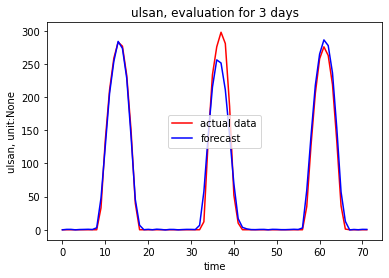

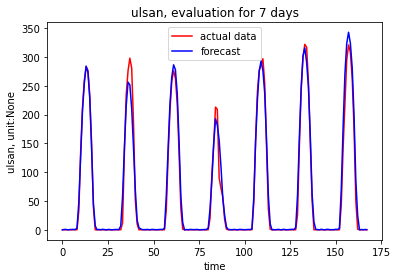

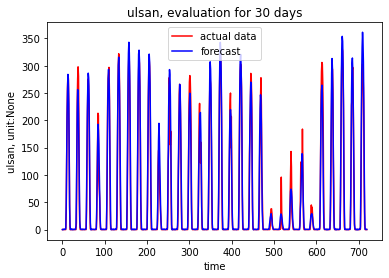

sola_nmae with 21.01.01 - 21.01.31 data with ulsan_data = 5.03


In [14]:
def sola_nmae(y_true, y_pred, cap = "ulsan"):
    if type(y_pred) is tf.float32:
        y_true = y_true.numpy()
        y_pred = y_pred.numpy()

    abs_err = np.abs(y_true - y_pred)
    abs_err /= capacity[cap]
    target_idx = np.where(y_pred >= capacity[cap] * 0.1)
    result = 100 * abs_err[target_idx].mean()
    return result

eval_ulsan = lambda x,y : sola_nmae(x, y, cap = "ulsan")

def custom_loss(y_true, y_pred):
    loss = tf.py_function(func = eval_ulsan, inp = [y_true, y_pred], Tout = tf.float32, name = "custom_nmae")
    print(loss)
    return loss


# ulsan model evaluation
# load model

model = tf.keras.models.load_model("ulsan_model.h5")

# evaluation
term_3d = range(0, 24 * 3)
term_7d = range(0, 24 * 7)
term_30d = range(0, 24 * 30)

# ulsan prediction
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
#x_name = ["Day_cos","Year_cos","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["ulsan"]

d_obs = ulsan_data[x_name].iloc[-24*30*1:].values.reshape(-1, 1, n_timesteps, n_features)
y_real = ulsan_data[y_name].iloc[-24*30*1:].values.reshape(-1,1)
y_pred = model.predict(d_obs).reshape(-1,1)

terms = [term_3d, term_7d, term_30d]
for term in terms:
    day = int(len(term) / 24)
    name = "ulsan, evaluation for " + str(day) + " days"
    plt.plot(y_real[term], 'r', label = "actual data")
    plt.plot(y_pred[term], 'b', label = "forecast")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("ulsan, unit:None")
    plt.title(name)
    plt.show()

ulsan_nmae = sola_nmae(y_real, y_pred, "ulsan")
print("sola_nmae with 21.01.01 - 21.01.31 data with %s = %.2f"%("ulsan_data", ulsan_nmae))

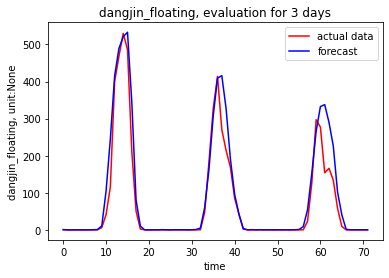

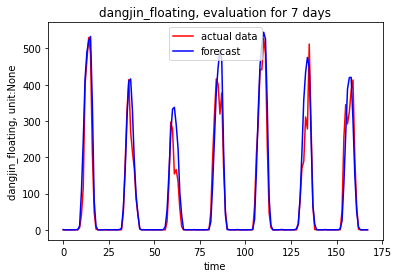

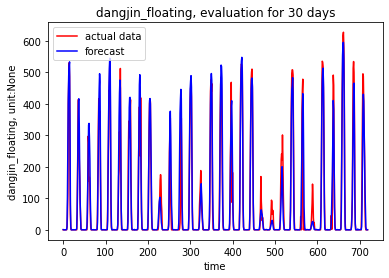

sola_nmae with 21.01.01 - 21.01.31 data with dangjin_floating = 6.89


In [15]:
# dangjin_floating model evaluation
# load model

model = tf.keras.models.load_model("dangjin_floating_model.h5")

# evaluation
term_3d = range(0, 24 * 3)
term_7d = range(0, 24 * 7)
term_30d = range(0, 24 * 30)

# ulsan prediction
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin_floating"]

d_obs = dangjin_data[x_name].iloc[-24*30*1:].values.reshape(-1, 1, n_timesteps, n_features)
y_real = dangjin_data[y_name].iloc[-24*30*1:].values.reshape(-1,1)
y_pred = model.predict(d_obs).reshape(-1,1)

terms = [term_3d, term_7d, term_30d]
for term in terms:
    day = int(len(term) / 24)
    name = "dangjin_floating, evaluation for " + str(day) + " days"
    plt.plot(y_real[term], 'r', label = "actual data")
    plt.plot(y_pred[term], 'b', label = "forecast")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("dangjin_floating, unit:None")
    plt.title(name)
    plt.show()

dangjin_floating_nmae = sola_nmae(y_real, y_pred, "dangjin_floating")
print("sola_nmae with 21.01.01 - 21.01.31 data with %s = %.2f"%("dangjin_floating", dangjin_floating_nmae))

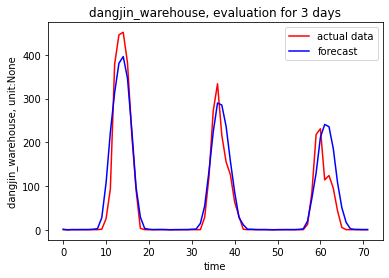

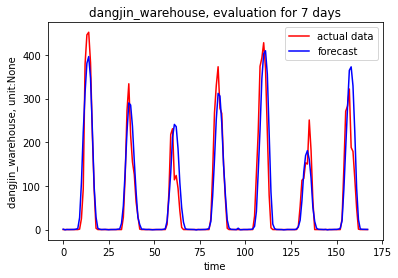

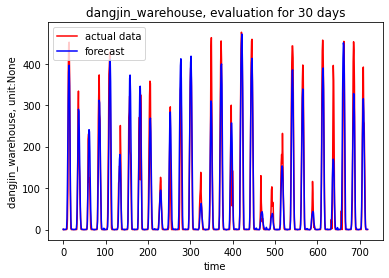

sola_nmae with 21.01.01 - 21.01.31 data with dangjin_warehouse = 8.92


In [16]:
# dangjin_warehouse model evaluation
# load model
model = tf.keras.models.load_model("dangjin_warehouse_model.h5")
# evaluation
term_3d = range(0, 24 * 3)
term_7d = range(0, 24 * 7)
term_30d = range(0, 24 * 30)

# ulsan prediction
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin_warehouse"]

d_obs = dangjin_data[x_name].iloc[-24*30*1:].values.reshape(-1, 1, n_timesteps, n_features)
y_real = dangjin_data[y_name].iloc[-24*30*1:].values.reshape(-1,1)
y_pred = model.predict(d_obs).reshape(-1,1)

terms = [term_3d, term_7d, term_30d]
for term in terms:
    day = int(len(term) / 24)
    name = "dangjin_warehouse, evaluation for " + str(day) + " days"
    plt.plot(y_real[term], 'r', label = "actual data")
    plt.plot(y_pred[term], 'b', label = "forecast")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("dangjin_warehouse, unit:None")
    plt.title(name)
    plt.show()

dangjin_warehouse_nmae = sola_nmae(y_real, y_pred, "dangjin_warehouse")
print("sola_nmae with 21.01.01 - 21.01.31 data with %s = %.2f"%("dangjin_warehouse", dangjin_warehouse_nmae))

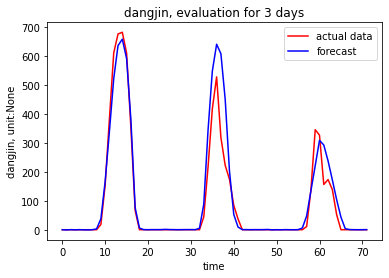

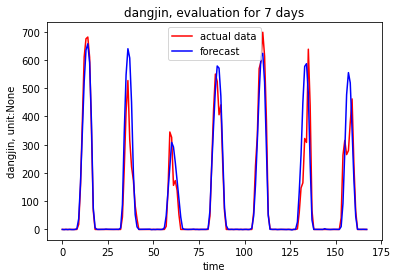

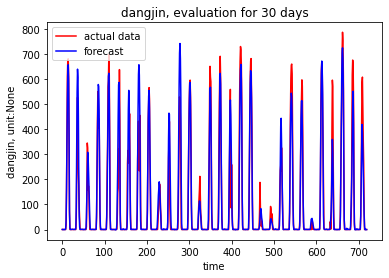

sola_nmae with 21.01.01 - 21.01.31 data with dangjin = 9.13


In [17]:
# dangjin model evaluation
# load model

model = tf.keras.models.load_model("dangjin_model.h5")

# evaluation
term_3d = range(0, 24 * 3)
term_7d = range(0, 24 * 7)
term_30d = range(0, 24 * 30)

# ulsan prediction
x_name = ["Day_cos","Day_sin","Year_cos","Year_sin","Temperature", "Wind_X", "Wind_Y", "Humidity", "Cloud"]
y_name = ["dangjin"]

d_obs = dangjin_data[x_name].iloc[-24*30*1:].values.reshape(-1, 1, n_timesteps, n_features)
y_real = dangjin_data[y_name].iloc[-24*30*1:].values.reshape(-1,1)
y_pred = model.predict(d_obs).reshape(-1,1)

terms = [term_3d, term_7d, term_30d]
for term in terms:
    day = int(len(term) / 24)
    name = "dangjin, evaluation for " + str(day) + " days"
    plt.plot(y_real[term], 'r', label = "actual data")
    plt.plot(y_pred[term], 'b', label = "forecast")
    plt.legend()
    plt.xlabel("time")
    plt.ylabel("dangjin, unit:None")
    plt.title(name)
    plt.show()

dangjin_nmae = sola_nmae(y_real, y_pred, "dangjin")
print("sola_nmae with 21.01.01 - 21.01.31 data with %s = %.2f"%("dangjin", dangjin_nmae))

In [18]:
from google.colab import files
# download model_weights
files.download('ulsan_weights.h5')
files.download('dangjin_floating_weights.h5')
files.download('dangjin_warehouse_weights.h5')
files.download('dangjin_weights.h5')

# download model
files.download("ulsan_model.h5")
files.download('dangjin_floating_model.h5')
files.download('dangjin_warehouse_model.h5')
files.download('dangjin_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>